<a href="https://colab.research.google.com/github/rcollmenendez/propulsion_challenges/blob/main/LogisticRegression_Banking_Deposit_subscription.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LogisticRegression - Banking client term deposit subscription

In [16]:
# Basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# sklearn ML objects
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score

## Data

**bank client data:**

1 - age (numeric)

2 - job : type of job

3 - marital : marital status

4 - education 

5 - default: has credit in default?

6 - housing: has housing loan?

7 - loan: has personal loan?

**related with the last contact of the current campaign:**

8 - contact: contact communication type

9 - month: last contact month of year

10 - day_of_week: last contact day of the week

11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

**other attributes:**
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)

14 - previous: number of contacts performed before this campaign and for this client (numeric)

15 - poutcome: outcome of the previous marketing campaign

**social and economic context attributes:**
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)

17 - cons.price.idx: consumer price index - monthly indicator (numeric)

18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)

19 - euribor3m: euribor 3 month rate - daily indicator (numeric)

20 - nr.employed: number of employees - quarterly indicator (numeric)

**Output variable (desired target):**

21 - y - has the client subscribed a term deposit?

In [2]:
data = pd.read_csv("/content/drive/MyDrive/0_data/04_MachineLearning/banking.csv")
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,44,blue-collar,married,basic.4y,unknown,yes,no,cellular,aug,thu,210,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,0
1,53,technician,married,unknown,no,no,no,cellular,nov,fri,138,1,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,0
2,28,management,single,university.degree,no,yes,no,cellular,jun,thu,339,3,6,2,success,-1.7,94.055,-39.8,0.729,4991.6,1
3,39,services,married,high.school,no,no,no,cellular,apr,fri,185,2,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,0
4,55,retired,married,basic.4y,no,yes,no,cellular,aug,fri,137,1,3,1,success,-2.9,92.201,-31.4,0.869,5076.2,1


In [3]:
data.shape

(41188, 21)

In [4]:
# Remove "data lekeage" variable "duration"
data = data.drop(columns="duration")

# Analysis Steps

1. Split data in Training and Test
2. Split training in categorical and numerical
3. Categorical to one hote encoding
4. Numerical to scale
5. Put the training data back together
6. Logistic regression

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  campaign        41188 non-null  int64  
 11  pdays           41188 non-null  int64  
 12  previous        41188 non-null  int64  
 13  poutcome        41188 non-null  object 
 14  emp_var_rate    41188 non-null  float64
 15  cons_price_idx  41188 non-null  float64
 16  cons_conf_idx   41188 non-null  float64
 17  euribor3m       41188 non-null 

In [6]:
# Check the different values for categorical variables
cat_var = data.select_dtypes(include=['object']).columns.tolist()

for col_name in cat_var:
  print("\n",col_name.upper())
  print(data[col_name].unique())


 JOB
['blue-collar' 'technician' 'management' 'services' 'retired' 'admin.'
 'housemaid' 'unemployed' 'entrepreneur' 'self-employed' 'unknown'
 'student']

 MARITAL
['married' 'single' 'divorced' 'unknown']

 EDUCATION
['basic.4y' 'unknown' 'university.degree' 'high.school' 'basic.9y'
 'professional.course' 'basic.6y' 'illiterate']

 DEFAULT
['unknown' 'no' 'yes']

 HOUSING
['yes' 'no' 'unknown']

 LOAN
['no' 'yes' 'unknown']

 CONTACT
['cellular' 'telephone']

 MONTH
['aug' 'nov' 'jun' 'apr' 'jul' 'may' 'oct' 'mar' 'sep' 'dec']

 DAY_OF_WEEK
['thu' 'fri' 'tue' 'mon' 'wed']

 POUTCOME
['nonexistent' 'success' 'failure']


In [7]:
X = data.drop(columns="y")
y = data["y"]

In [12]:
# Categorical and numerical variables
cat_var = X.select_dtypes(include=['object']).columns.tolist()
num_var = X.select_dtypes(include=['int64', 'float']).columns.tolist()

print("Num of cat variables:", len(cat_var))
print("Num of numerical variables:", len(num_var))

Num of cat variables: 10
Num of numerical variables: 9


# Split data in training and test

In [14]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=5)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((28831, 19), (12357, 19), (28831,), (12357,))

# Split training data in categorical and numerical

In [15]:
X_train_cat = X_train[cat_var]
X_train_num = X_train[num_var]

X_train_cat.shape, X_train_num.shape

((28831, 10), (28831, 9))

# Categorical data to OneHotEncoding

Create "dummy" variables for each value of each categorical variable with the value 1 or 0.

Example:

- Original variable: MARITAL

- Original values: ['married' 'single' 'divorced' 'unknown']

- New variables: [MARITAL_married, MARITAL_single, MARITAL_divorced, MARITAL_unknown]

- New values: [1, 0]



In [20]:
# Initialize the OneHotEncoder
cat_dummy_encoder = OneHotEncoder(handle_unknown='ignore')

# Fit the training data
X_train_cat_ohe = cat_dummy_encoder.fit_transform(X_train_cat).toarray()

# Put data back in a df
cat_ohe_cols = cat_dummy_encoder.get_feature_names(cat_var)
X_train_cat_ohe = pd.DataFrame(X_train_cat_ohe, 
                               columns=cat_ohe_cols)

print(X_train_cat_ohe.shape) 

X_train_cat_ohe.head(5)

(28831, 53)


,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,marital_unknown,education_basic.4y,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,default_no,default_unknown,default_yes,housing_no,housing_unknown,housing_yes,loan_no,loan_unknown,loan_yes,contact_cellular,contact_telephone,month_apr,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


# Numerical data to StandardScaler

In [19]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
X_train_num_scaled = ss.fit_transform(X_train_num)

# Create df
X_train_num_scaled = pd.DataFrame(X_train_num_scaled, 
                                  columns=num_var)

print(X_train_num_scaled.shape)

X_train_num_scaled.head()

(28831, 9)


,age,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed
0,-0.772080,-0.559728,0.195081,-0.350426,0.645782,0.721816,0.889023,0.712095,0.329604
1,1.337858,0.144383,0.195081,-0.350426,0.645782,0.721816,0.889023,0.711519,0.329604
2,-0.484361,0.144383,0.195081,-0.350426,0.645782,0.721816,0.889023,0.713248,0.329604
3,0.762420,0.144383,0.195081,-0.350426,0.645782,0.721816,0.889023,0.712672,0.329604
4,-1.251612,-0.559728,0.195081,-0.350426,0.836542,0.590569,-0.471378,0.772062,0.843689


# Put X_train back together

In [21]:
# Put X_train together
X_train = pd.concat([X_train_num_scaled, X_train_cat_ohe], axis=1)
X_train.shape

(28831, 62)

# Apply changes to Test data

In [ ]:
# Split the test data in categorical and numerical variables
X_test_cat = X_test[cat_var]
X_test_num = X_test[num_var]

# Apply the One hot encoder to the categorical test data
X_test_cat_ohe = cat_dummy_encoder.transform(X_test_cat).toarray()
X_test_cat_ohe = pd.DataFrame(X_test_cat_ohe, 
                               columns=cat_ohe_cols)

# Apply the standard scaler to the numerical test data
X_test_num_scaled = ss.transform(X_test_num)

X_test_num_scaled = pd.DataFrame(X_test_num_scaled, 
                                  columns=num_var)

# Put the test data back together
X_test = pd.concat([X_test_num_scaled, X_test_cat_ohe], axis=1)

print(X_test.shape)
X_test.head()

(12357, 62)


,age,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,marital_unknown,education_basic.4y,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,default_no,default_unknown,default_yes,housing_no,housing_unknown,housing_yes,loan_no,loan_unknown,loan_yes,contact_cellular,contact_telephone,month_apr,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,1.913296,0.848494,0.195081,-0.350426,0.645782,0.721816,0.889023,0.710365,0.329604,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,-0.196643,-0.207673,0.195081,-0.350426,-0.117260,-0.649371,-0.320222,0.261193,0.396117,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,-0.100736,-0.559728,0.195081,-0.350426,-0.117260,-0.649371,-0.320222,0.305591,0.396117,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0.858326,-0.559728,0.195081,-0.350426,-1.198235,-1.179540,-1.227156,-1.314082,-0.943828,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,1.050139,-0.207673,0.195081,-0.350426,0.836542,0.590569,-0.471378,0.771485,0.843689,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


# Confusion matrix and Classification report

# Experiment 1 - Class weight=balanced

In [ ]:
# Create the logistic regression instance
log_reg = LogisticRegression(random_state=42, solver='liblinear')

# Calculate the coefficients based on the training data
log_reg.fit(X_train, y_train)

# Predict the y of based on the test data
y_pred = log_reg.predict(X_test)

# Extract the labels
class_labels = log_reg.classes_

# Create a dataframe with the confussion matrix
pd.DataFrame(confusion_matrix(y_test, y_pred), 
             columns=class_labels, index=class_labels)

,0,1
0,10804,182
1,1046,325


In [ ]:
# Main metrics of the performance of the model in terms of prediction
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.98      0.95     10986
           1       0.64      0.24      0.35      1371

    accuracy                           0.90     12357
   macro avg       0.78      0.61      0.65     12357
weighted avg       0.88      0.90      0.88     12357



# Comparing models

In [ ]:
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score

scores_df = pd.DataFrame()

for c in np.arange(0.1, 1, 0.2):
  
  cv = RepeatedKFold(n_splits=3, random_state=1)
  
  l1_pen = LogisticRegression(penalty='l1', random_state=42, solver='liblinear', class_weight='balanced', C=c)
  l1_scores = cross_val_score(l1_pen, X_train, y_train, scoring='f1', cv=cv)
  l1_scores = np.mean(l1_scores)

  l2_pen = LogisticRegression(penalty='l2', random_state=42, solver='liblinear', class_weight='balanced', C=c)
  l2_scores = cross_val_score(l2_pen, X_train, y_train, scoring='f1', cv=cv)
  l2_scores = np.mean(l2_scores)

  scores_df = scores_df.append({ 'C': c, 
    'l1_score': l1_scores,
    'l2_score' : l2_scores
  }, ignore_index=True)


0.1
0.30000000000000004
0.5000000000000001
0.7000000000000001
0.9000000000000001


In [ ]:
scores_df

,C,l1_score,l2_score
0,0.1,0.453257,0.453834
1,0.3,0.456190,0.455928
2,0.5,0.456430,0.456052
3,0.7,0.456526,0.456182
4,0.9,0.456507,0.456250


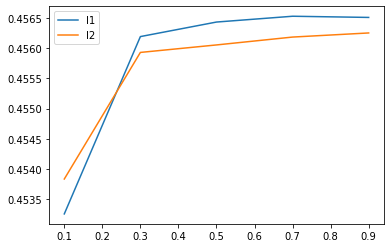

In [ ]:
fig, ax = plt.subplots()

ax.plot(scores_df["C"], scores_df["l1_score"], label="l1")
ax.plot(scores_df["C"], scores_df["l2_score"], label="l2")
ax.legend()

plt.show()

# Best model

In [ ]:
log_reg = LogisticRegression(penalty='l1', random_state=42, solver='liblinear', class_weight='balanced', C=0.7)

In [ ]:
log_reg.fit(X_train, y_train)

y_pred = log_reg.predict(X_test)

class_labels = log_reg.classes_

pd.DataFrame(confusion_matrix(y_test, y_pred), 
             columns=class_labels, index=class_labels)

,0,1
0,9350,1636
1,527,844


In [ ]:
# Precision and recall
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.85      0.90     10986
           1       0.34      0.62      0.44      1371

    accuracy                           0.82     12357
   macro avg       0.64      0.73      0.67     12357
weighted avg       0.88      0.82      0.85     12357

